## Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re, string

from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")

from collections import Counter

import nltk 
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# import model libraries 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV


In [2]:
reddit = pd.read_csv('Reddit_Data.csv')
twitter = pd.read_csv('Twitter_Data.csv')

# Exploratory Data Analysis
## Survey and Combine Reddit and Twitter Dataframes

In [3]:
reddit.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
twitter.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [5]:
reddit.columns = ['text','status']
twitter.columns = ['text','status']
df = pd.concat([reddit, twitter], ignore_index = True)
df.head()

,text,status
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0


## Eliminate null or missing data

In [6]:
df.isna().sum()

text      104
status      7
dtype: int64

In [7]:
df=df.dropna()

## Eliminate duplicates in data

Check for duplicates in 'text' column

In [8]:
df["text"].duplicated().sum()

410

1. Assessing columns with duplicates
+ blank records
+ file type names: jpg
2. Remove duplicates
+ higher occurence of certain words may mislead the model to over-estimate their importance

In [9]:
df[df["text"].duplicated()].head(n=10)

,text,status
375,,0.0
392,,0.0
617,aurum mom,0.0
651,,0.0
1222,,0.0
1528,,0.0
1613,attention please keep mind that the this thre...,1.0
1760,jpg,0.0
1835,,0.0
1858,jpg,0.0


In [10]:
print(df[df['text']==" "].shape)

(116, 2)


In [11]:
df=df.drop_duplicates()

## Class Distribution Analysis

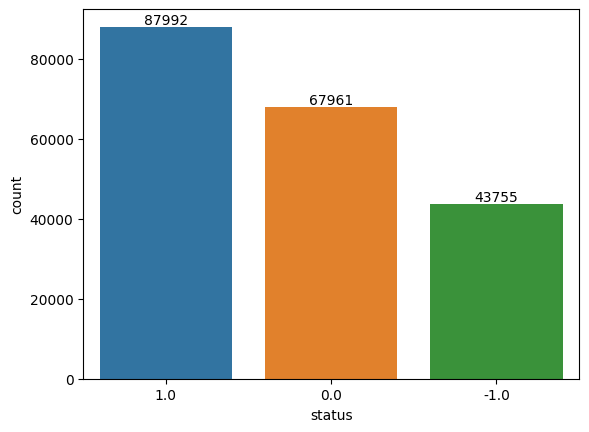

In [12]:
ax = sns.countplot(x=df["status"], 
              order = df["status"].value_counts(ascending = False).index)
abs_values = df["status"].value_counts(ascending = False).values
ax.bar_label(container = ax.containers[0],labels=abs_values)
plt.show()

In [13]:
fig = px.pie(df, 
             names='status', 
             title="Percentage composition of each status in the dataset")
fig.show()

## Text Cleaning
+ conduct checks for presence of special characters
    + unicode
    + numeric digits
    + hyperlink prefixes: www or https
+ eliminate special characters present that will nto be relevant for language analysis 

In [14]:
# list of special characters/punctuation to search for in data
pat_list = [r'-', r'\+', r':', r'!', r'\?', r'\.', r'\\n', r'https?://\S+|www\.\S+', r'\w*\d\w*'] 

def punc_search(df, col, pat):
    """
    function that counts the number of occurences of special characters and punctuation
    """
    for p in pat:
        v = df[col].str.contains(p).sum() # total n_rows that contain the pattern
        print(f'{p} is present in {v} entries')

punc_search(df, 'text', pat_list)

- is present in 0 entries
\+ is present in 0 entries
: is present in 0 entries
! is present in 0 entries
\? is present in 0 entries
\. is present in 0 entries
\\n is present in 1 entries
https?://\S+|www\.\S+ is present in 0 entries
\w*\d\w* is present in 29637 entries


In [15]:
def clean_text(text):
    '''
    Function to clean text by converting all characters to lower case, removing breaks and links.
    '''
    text = str(text).lower()
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    


df['text']=df['text'].apply(lambda x:clean_text(x))

In [16]:
df.head(10)

,text,status
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0
5,you should all sit down together and watch the...,-1.0
6,was teens when discovered zen meditation was ...,1.0
7,jesus was zen meets jew,0.0
8,there are two varieties christians dogmatic th...,-1.0
9,dont worry about trying explain yourself just ...,1.0


## Derive frequency of appearance of words

In [17]:
word_list = df['text'].apply(lambda x:str(x).split())
top = Counter([word for sentence in word_list for word in sentence ])
word_df = pd.DataFrame(top.most_common(10))
word_df.columns=['Words','Count']
word_df.style.background_gradient(cmap='Blues')

,Words,Count
0,the,161556
1,modi,154657
2,and,95750
3,for,65205
4,you,49972
5,that,42846
6,this,41554
7,are,38486
8,not,37864
9,will,35721


Positive sentiment word frequency

In [18]:
pos = df[df['status']==1]
pos_list = pos['text'].apply(lambda x:str(x).split())
top_pos = Counter([word for sentence in pos_list for word in sentence if word not in set(stopwords.words('english'))])
pos_df = pd.DataFrame(top_pos.most_common(20))
pos_df.columns=['Words','Count']

fig = px.bar(pos_df, x="Count", y="Words", title='Positive Words with the Highest Frequency', orientation='h', color_continuous_scale="Aggrnyl",
             width=700, height=700,color='Count')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

Negative word sentiment frequency

In [19]:
neg = df[df['status'] == -1]
neg_list = neg['text'].apply(lambda x:str(x).split())
top_neg = Counter([word for sentence in neg_list for word in sentence if word not in set(stopwords.words('english'))])
neg_df = pd.DataFrame(top_neg.most_common(20))
neg_df.columns=['Words','Count']

fig = px.bar(neg_df, x="Count", y="Words", title='Negative Words with the Highest Frequency', orientation='h', color_continuous_scale="YlOrRd",
             width=700, height=700,color='Count')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

Neutral word sentiment frequency

In [20]:
neutral = df[df['status']== 0]
neutral_list = neutral['text'].apply(lambda x:str(x).split())
top_neutral = Counter([word for sentence in neutral_list for word in sentence if word not in set(stopwords.words('english'))])
neutral_df = pd.DataFrame(top_neutral.most_common(20))
neutral_df.columns=['Words','Count']

fig = px.bar(neutral_df, x="Count", y="Words", title='Neutral Words with the Highest Frequency', orientation='h', color_continuous_scale="haline",
             width=700, height=700,color='Count')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

## Expansion of stopwords
+ Overlap of top 4 most common words between positive and negative sentiments, which hinders the process of meaningful comparison between both.
+ Large disparity between frequency of word "modi" and other words, which skews view of the bar plot for all three sentiments
+ Expand stopwords to include top few commonly appearing words shared by the three sentiments as they do not enhance understanding of classification outcomes

In [21]:
new_stopwords =['modi','india','bjp','like','people']

def plot_word_frequency(data, stopwords_list, top_n, label, color_scale):
    newlist = data['text'].apply(lambda x:str(x).split())
    stopwords_final = stopwords.words('english')
    stopwords_final.extend(stopwords_list)
    top = Counter([word for sentence in newlist for word in sentence if word not in stopwords_final])
    pos_df = pd.DataFrame(top.most_common(top_n))
    pos_df.columns=['Words','Count']
    fig = px.bar(pos_df, 
                 x="Count", 
                 y="Words", 
                 title='{} Words with the Highest Frequency'.format(label), orientation='h', 
                 color_continuous_scale=color_scale,
                 width=700, 
                 height=700,
                 color='Count')
    fig.update_layout(yaxis=dict(autorange="reversed"))
    fig.show()

In [22]:
plot_word_frequency(pos, new_stopwords, 20, "Positive", "Aggrnyl")

In [23]:
plot_word_frequency(neg, new_stopwords, 20, "Negative", "Oxy")

In [24]:
plot_word_frequency(neutral, new_stopwords, 20, "Neutral", "Picnic")

## Word cloud

In [25]:
def word_cloud(data, stopwords_list, color_scale):
    text = " ".join(word for word in data['text'])
    stopwords = set(STOPWORDS)
    stopwords.update(stopwords_list)

    wordcloud = WordCloud(stopwords = stopwords, 
                        background_color = "white",
                        max_words = 300,
                        width = 600,
                        height = 400,
                        colormap = color_scale).generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Distribution of positive sentiment words

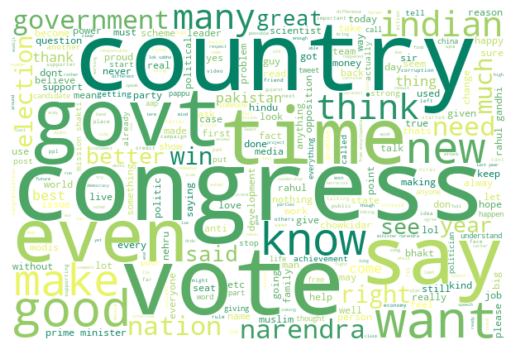

In [26]:
wc_stopwords = new_stopwords.copy()
wc_stopwords.extend(["will","now","one"])
word_cloud(pos, wc_stopwords, "summer")

Distribution of negative sentiment words

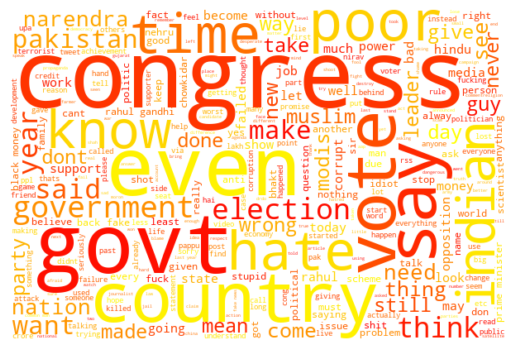

In [27]:
word_cloud(neg, wc_stopwords, "autumn")

Distribution of neutral sentiment words

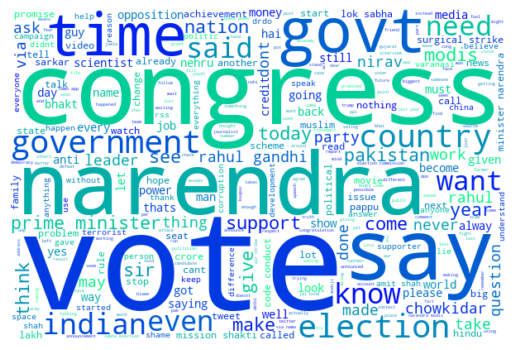

In [28]:
word_cloud(neutral, wc_stopwords, "winter")

Initiate Machine Learning Models

In [29]:
text=df['text']
status=df['status']

tfidf_vec = TfidfVectorizer()
text_tfidf = tfidf_vec.fit_transform(text)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(text_tfidf, status, stratify=status, test_size=0.2, random_state=42, shuffle=True)

In [31]:
models = [LogisticRegression(max_iter=500),
          LinearSVC(dual="auto"),
          DecisionTreeClassifier(max_depth=3,min_samples_split=2),
          RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
          GradientBoostingClassifier(n_estimators=20, learning_rate=0.1,max_features=1),
          MultinomialNB(),
          SGDClassifier(max_iter=500,loss="hinge",n_jobs=-1)
          ]

scoring = ['accuracy', 'f1_macro','recall_macro','precision_macro']
kf = StratifiedKFold(n_splits=5, shuffle=True)

def initialise_models(model_list,scoring_list, X_train, y_train):
    for model in tqdm(model_list):
        model_name=model.__class__.__name__
        result= cross_validate(model,X_train,y_train,cv=kf,scoring=scoring_list)
        print("{}:\n Mean Accuracy = {:.2f}% \n Mean F1-macro = {:.2f}% \n Mean recall-macro = {:.2f}% \n Mean precision-macro = {:.2f}%" 
          .format(model_name, 
             result['test_accuracy'].mean()*100, 
             result['test_f1_macro'].mean()*100, 
             result['test_recall_macro'].mean()*100, 
             result['test_precision_macro'].mean()*100))
        print("Initialisation of {} model completed.".format(model_name))

In [32]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '5'

initialise_models(models,scoring, X_train, y_train)

 14%|█▍        | 1/7 [03:31<21:06, 211.15s/it]

LogisticRegression:
 Mean Accuracy = 91.40% 
 Mean F1-macro = 90.36% 
 Mean recall-macro = 89.84% 
 Mean precision-macro = 91.32%
Initialisation of LogisticRegression model completed.


 29%|██▊       | 2/7 [03:55<08:27, 101.47s/it]

LinearSVC:
 Mean Accuracy = 93.75% 
 Mean F1-macro = 93.06% 
 Mean recall-macro = 92.79% 
 Mean precision-macro = 93.43%
Initialisation of LinearSVC model completed.


 43%|████▎     | 3/7 [05:52<07:14, 108.56s/it]

DecisionTreeClassifier:
 Mean Accuracy = 48.46% 
 Mean F1-macro = 36.49% 
 Mean recall-macro = 42.18% 
 Mean precision-macro = 52.51%
Initialisation of DecisionTreeClassifier model completed.


 57%|█████▋    | 4/7 [07:54<05:41, 113.74s/it]

RandomForestClassifier:
 Mean Accuracy = 44.06% 
 Mean F1-macro = 20.39% 
 Mean recall-macro = 33.33% 
 Mean precision-macro = 21.35%
Initialisation of RandomForestClassifier model completed.


 71%|███████▏  | 5/7 [08:29<02:50, 85.30s/it] 

GradientBoostingClassifier:
 Mean Accuracy = 44.06% 
 Mean F1-macro = 20.39% 
 Mean recall-macro = 33.33% 
 Mean precision-macro = 14.69%
Initialisation of GradientBoostingClassifier model completed.


 86%|████████▌ | 6/7 [08:30<00:56, 56.52s/it]

MultinomialNB:
 Mean Accuracy = 54.30% 
 Mean F1-macro = 39.87% 
 Mean recall-macro = 44.19% 
 Mean precision-macro = 78.66%
Initialisation of MultinomialNB model completed.


100%|██████████| 7/7 [08:33<00:00, 73.29s/it]

SGDClassifier:
 Mean Accuracy = 84.31% 
 Mean F1-macro = 82.03% 
 Mean recall-macro = 81.16% 
 Mean precision-macro = 86.08%
Initialisation of SGDClassifier model completed.


# Logistic Regression
## Hyperparameter tuning for Logistic Regression model

In [33]:
lr_params= {'penalty': ['l1','l2'], 
          'C': [0.001,0.01,0.1,1,10,100,1000]}

LRgrid = GridSearchCV(estimator = LogisticRegression(),  
                           param_grid = lr_params,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


LRgrid.fit(X_train, y_train)
print(LRgrid.best_params_)


{'C': 1000, 'penalty': 'l2'}


In [34]:
print(LRgrid.best_score_)

0.9331334581414966


In [35]:
LRgrid = LogisticRegression(penalty='l2',
                            C=1000,
                            verbose=0)
LRgrid.fit(X_train, y_train)

LogisticRegression(C=1000)

## Evaluation of Logistic Regression model

In [36]:
# best params derived through gridsearchsv above: {'C': 1000, 'penalty': 'l2'}
LRpred=LRgrid.predict(X_test)
print(classification_report(y_test,LRpred))

              precision    recall  f1-score   support

        -1.0       0.90      0.87      0.89      8751
         0.0       0.94      0.98      0.96     13592
         1.0       0.95      0.94      0.94     17599

    accuracy                           0.94     39942
   macro avg       0.93      0.93      0.93     39942
weighted avg       0.94      0.94      0.94     39942



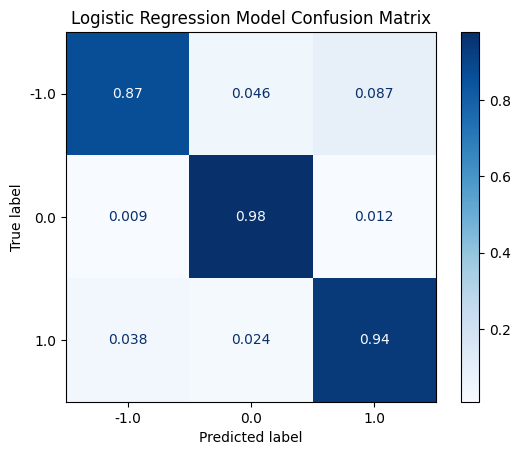

In [37]:
LR_cm = confusion_matrix(y_test,LRpred)
disp = ConfusionMatrixDisplay.from_estimator(LRgrid,X_test,y_test,cmap=plt.cm.Blues,normalize='true')
disp.ax_.set_title("Logistic Regression Model Confusion Matrix")
plt.show()

# Stochastic Gradient Descent Classifier
## Hyperparameter tuning for SGDClassifier

In [38]:
sgd_params= {'penalty':['l2'],
            'loss':['hinge','squared_hinge','log_loss'],
            'alpha': [0.00001,0.0001,0.001,0.01,0.1,1],
            'max_iter':[1000]}

SGDgrid = GridSearchCV(estimator = SGDClassifier(),  
                           param_grid = sgd_params,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0,
                           n_jobs=-1)


SGDgrid.fit(X_train, y_train)
print(SGDgrid.best_params_)

{'alpha': 1e-05, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}


In [39]:
print(SGDgrid.best_score_)

0.9328330200024786


## Evaluation of SGDClassifier()

In [40]:
SGDgrid = SGDClassifier(alpha = 0.00001,
                        loss = 'hinge',
                        max_iter = 1000,
                        penalty = 'l2',
                        verbose = 0,
                        n_jobs = -1)

In [41]:
#{'alpha': 0.001, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}
SGDgrid.fit(X_train, y_train)
SGDpred=SGDgrid.predict(X_test)
print(classification_report(y_test,SGDpred))

              precision    recall  f1-score   support

        -1.0       0.93      0.85      0.88      8751
         0.0       0.94      0.98      0.96     13592
         1.0       0.94      0.95      0.94     17599

    accuracy                           0.94     39942
   macro avg       0.93      0.92      0.93     39942
weighted avg       0.94      0.94      0.94     39942



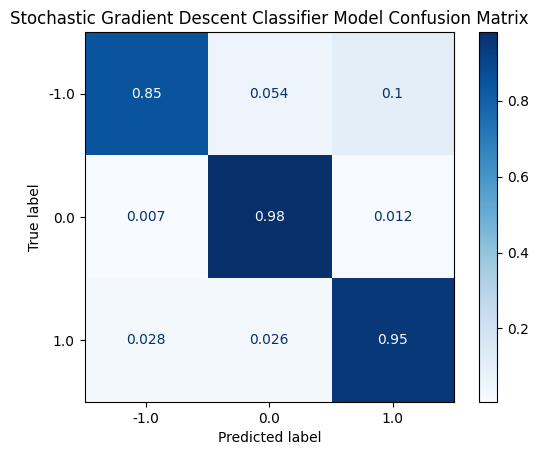

In [42]:
SGD_cm = confusion_matrix(y_test,SGDpred)
disp = ConfusionMatrixDisplay.from_estimator(SGDgrid,X_test,y_test,cmap=plt.cm.Blues,normalize='true')
disp.ax_.set_title("Stochastic Gradient Descent Classifier Model Confusion Matrix")
plt.show()

# Linear SVC model
## Hyperparameter tuning for LinearSVC() model

In [43]:
svc_params= {'penalty': ['l1'], 
            'loss':['hinge','squared_hinge'],
            'dual': ['auto'],
            'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

SVCgrid = GridSearchCV(estimator = LinearSVC(),    
                           param_grid = svc_params,    
                           scoring = 'accuracy',     
                           cv = 5,       
                           verbose=0,
                           n_jobs=-1)


SVCgrid.fit(X_train, y_train)
print(SVCgrid.best_params_)

{'C': 1, 'dual': 'auto', 'loss': 'squared_hinge', 'penalty': 'l1'}


## Evaluation of LinearSVC()

In [44]:
print(SVCgrid.best_score_)

0.9534631891244331


In [45]:
#{'C': 1, 'dual': 'auto', 'loss': 'squared_hinge', 'penalty': 'l1'}
SVMpred = SVCgrid.predict(X_test)
print(classification_report(y_test,SVMpred))

              precision    recall  f1-score   support

        -1.0       0.93      0.91      0.92      8751
         0.0       0.97      0.98      0.98     13592
         1.0       0.96      0.96      0.96     17599

    accuracy                           0.96     39942
   macro avg       0.95      0.95      0.95     39942
weighted avg       0.96      0.96      0.96     39942



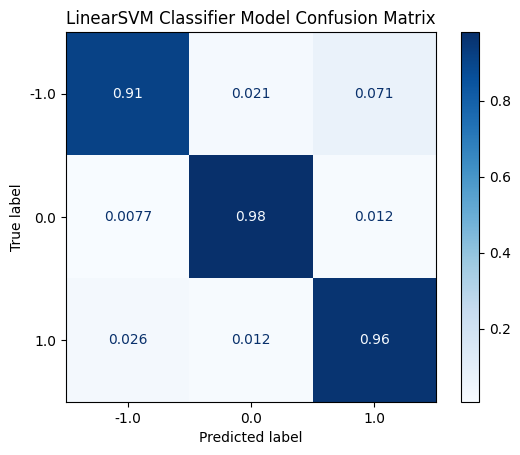

In [46]:
SVM_cm = confusion_matrix(y_test,SVMpred)
disp = ConfusionMatrixDisplay.from_estimator(SVCgrid,X_test,y_test,cmap=plt.cm.Blues,normalize='true')
disp.ax_.set_title("LinearSVM Classifier Model Confusion Matrix")
plt.show()